In [150]:
import tifffile
import numpy as np
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [152]:
in_dir = r'.\\hch_pellet_016\\markers'
mask = tifffile.imread(r'.\\hch_pellet_016\\Mask.tif').astype('float')
out_dir = r'.\\hch_pellet_016'
gene_names = ['ccl11', 'col5a2', 'sox9', 'actb', 'eef2', 'spp1', 'runx1', 'pdl1', 'col1a1', 'il8', 'il6']

In [154]:
fnl = os.listdir(in_dir)
fnl.sort()
im_l = []
for i in range(1,12):
    print(fnl[i])
    im_l.append(tifffile.imread(os.path.join(in_dir, fnl[i])))
mask = mask + 100
mask = (mask>0).astype('float')

10_ccl11_C4-hch_il8_il6_ccl11_016-2.tif
11_col5a2_C3-hch_col5a2_016-1.tif
1_sox9_C3-hch_sox9_actb_016-2.tif
2_actb_C4-hch_sox9_actb_016-2.tif
3_eef2_C3-hch_eef2_spp1_016-2.tif
4_spp1_C4-hch_eef2_spp1_016-2.tif
5_runx1_C3-hch_runx1_pdl1_016-2_masked.tif
6_pdl1_C4-hch_runx1_pdl1_016-2.tif
7_col1a1_C3-hch_col1a1_016-2.tif
8_il8_C2-hch_il8_il6_ccl11_016-2.tif
9_il6_C3-hch_il8_il6_ccl11_016-2.tif


In [155]:
# Extract points from mask
imgs = np.stack(im_l)
stacked_list = []
k = 0
for i in range(imgs.shape[2]):
    for j in range(imgs.shape[3]):
        if mask[i,j] == 1:
            stacked_list.append(imgs[:,:,i,j])
stacked = np.concatenate(stacked_list, axis=1).T.astype('float')

In [156]:
mean = np.mean(stacked, axis=0)
std = np.std(stacked, axis=0)
stacked_norm = (stacked - mean) / (std+0.0001)
# print(np.min(std))

Determine number of clusters

In [135]:
sww = []
for i in range(4, 15):
    kmeans = KMeans(n_clusters = i).fit(stacked_norm)
    centers = kmeans.cluster_centers_
    prediction = kmeans.predict(stacked_norm)
    swwi = 0
    for j in range(i):
        temp_mask = (prediction == j).astype('int')
        diff = stacked_norm - centers[j,:]
        diff = diff * diff
        diff = np.sum(diff, axis=1)
        swwi = swwi + np.sum(diff * temp_mask)
    sww.append(swwi)

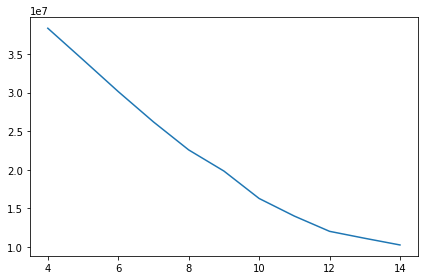

In [149]:
x = np.arange(4,15)
plt.plot(x, sww)
plt.savefig(os.path.join(out_dir, r'gene_cluster_kvalue.png'))

In [148]:
plt.savefig(os.path.join(out_dir, r'gene_cluster_kvalue.png'))

<Figure size 432x288 with 0 Axes>

In [157]:
N_CLUSTERS = 12

In [158]:
kmeans = KMeans(n_clusters = N_CLUSTERS).fit(stacked_norm)

In [159]:
# Normalize per slice
imgs_norm = np.zeros(imgs.shape)
for i in range(imgs.shape[1]):
    temp = imgs[:,i,:,:].reshape((imgs.shape[0], imgs.shape[2]*imgs.shape[3]))
    imgs_norm[:,i,:,:] = (temp.T - mean / (std+0.0001)).T.reshape((imgs.shape[0], imgs.shape[2], imgs.shape[3]))
print(imgs_norm.shape)

(11, 35, 390, 390)


In [160]:
predictions = kmeans.predict(stacked_norm)
print(stacked_norm.shape)

(5323500, 11)


In [161]:
# Cluster ranking
gene_cluster_stack = np.zeros((stacked_norm.shape[0],N_CLUSTERS))
for i in range(N_CLUSTERS):
    gene_cluster_stack[:,i] = (predictions == i).astype('int')
n_pixels = np.sum(gene_cluster_stack, axis=0)
orders = np.argsort(n_pixels)

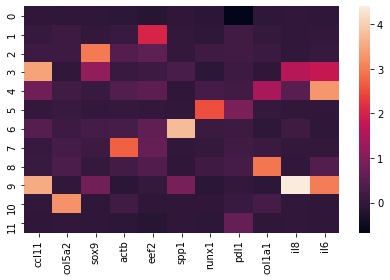

In [162]:
centers = kmeans.cluster_centers_
sorted_centers = centers[orders]
log_centers = np.log(centers+1)
sns_plot = sns.heatmap(log_centers, xticklabels=gene_names)

In [163]:
fig = sns_plot.get_figure()
fig.savefig(os.path.join(out_dir,r'gene_clusters_heatmap.png'))

In [164]:
# Generate per slice clustering
predictions = np.zeros((imgs.shape[1], imgs.shape[2], imgs.shape[3]))
for i in range(imgs.shape[1]):
    temp = imgs_norm[:,i,:,:].reshape((imgs_norm.shape[0], imgs.shape[2]*imgs.shape[3]))
    predictions[i,:,:] = kmeans.predict(temp.T).T.reshape((imgs.shape[2], imgs.shape[3]))

In [165]:
for i in range(N_CLUSTERS):
    cluster_i = ((predictions == i)*255).astype('uint8')
    for j in range(cluster_i.shape[0]):
        cluster_i[j,:,:] = cluster_i[j,:,:] * mask
    # save_dir = r'Y:\\coskun-lab\\Zhou\\4_HCR\\20210525_hchPellet\\0_clustering_data\\016\\clustering_result\\v4'
    save_name = 'cluster_' + str(i) + '.tif'
    tifffile.imsave(os.path.join(out_dir, save_name), cluster_i.astype('uint8'))